# 04 — Résultats et Comparaison des Modèles
## Projet HVAC Market Analysis — Synthèse Phase 4

**Objectif** : Synthétiser et analyser les résultats de tous les modèles entraînés.

**Plan** :
1. Charger les résultats
2. Tableau comparatif final
3. Visualisations des prédictions
4. Feature importance (SHAP)
5. Analyse des erreurs
6. Recommandations finales

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

from config.settings import config
print('Imports OK')

Imports OK


---
## 1. Charger les résultats de l'entraînement

Les résultats ont été sauvegardés par `python -m src.pipeline train` dans `data/models/`.

In [2]:
# ============================================================
# 1.1 — Charger le résumé CSV
# ============================================================
results_path = Path('../data/models/training_results.csv')
if results_path.exists():
    df_results = pd.read_csv(results_path)
    print(f'Résultats chargés : {len(df_results)} modèles')
    display(df_results)
else:
    print('Pas de résultats trouvés. Lancer : python -m src.pipeline train')

Résultats chargés : 4 modèles


,model,target,val_rmse,val_mae,val_mape,val_r2,test_rmse,test_mae,test_mape,test_r2,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,cv_mape_mean,cv_mape_std,cv_r2_mean,cv_r2_std
0,ridge,nb_installations_pac,1.099830,0.924057,2.979431,0.997436,0.964580,0.766490,2.110807,0.998200,2.421408,0.674435,1.731223,0.493045,6.050374,1.223563,0.965158,0.025259
1,lightgbm,nb_installations_pac,5.006810,3.728523,9.222892,0.946865,8.124242,5.535405,11.973710,0.872279,10.207003,6.163619,7.082949,4.049790,17.051075,3.813859,0.535358,0.274077
2,prophet,nb_installations_pac,13.747888,9.952669,27.094623,0.599384,12.051773,9.567115,25.693512,0.718940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lstm,nb_installations_pac,22.811642,15.505029,35.391220,-0.102984,26.257505,19.218626,37.932619,-0.334146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# ============================================================
# 1.2 — Charger le dataset et recréer les splits
# ============================================================
TARGET = 'nb_installations_pac'
TRAIN_END = 202406
VAL_END = 202412

df = pd.read_csv('../data/features/hvac_features_dataset.csv')

# Splits
df_train = df[df['date_id'] <= TRAIN_END].copy()
df_val = df[(df['date_id'] > TRAIN_END) & (df['date_id'] <= VAL_END)].copy()
df_test = df[df['date_id'] > VAL_END].copy()

# Axe temporel
df['date'] = pd.to_datetime(
    df['date_id'].astype(str).str[:4] + '-' + 
    df['date_id'].astype(str).str[4:] + '-01'
)

print(f'Train : {len(df_train)} | Val : {len(df_val)} | Test : {len(df_test)}')

Train : 288 | Val : 48 | Test : 96


In [4]:
# ============================================================
# 1.3 — Charger les modèles sauvegardés et re-prédire
# ============================================================
# IMPORTANT : on utilise le même EXCLUDE_COLS que train.py
# pour que les features correspondent aux modèles sauvegardés

models_dir = Path('../data/models')

# Colonnes exclues (identifiants + métadonnées)
# Les pct_* ne sont PAS exclues car les modèles ont été entraînés avec
EXCLUDE_COLS = {
    'date_id', 'dept', 'dept_name', 'city_ref', 'latitude', 'longitude',
    'n_valid_features', 'pct_valid_features',
}
# Variables cibles (on garde toutes SAUF celle qu'on prédit)
OTHER_TARGETS = {
    'nb_installations_clim', 'nb_dpe_total', 'nb_dpe_classe_ab',
}

feature_cols = [
    c for c in df.columns
    if c not in EXCLUDE_COLS and c not in OTHER_TARGETS and c != TARGET
    and df[c].dtype in [np.float64, np.int64, np.float32, np.int32]
]

# Préparer X et y
X_train, y_train = df_train[feature_cols], df_train[TARGET]
X_val, y_val = df_val[feature_cols], df_val[TARGET]
X_test, y_test = df_test[feature_cols], df_test[TARGET]

# Imputation et scaling
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_val_imp = pd.DataFrame(imputer.transform(X_val), columns=feature_cols, index=X_val.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=feature_cols, index=X_test.index)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=feature_cols, index=X_test.index)

# Charger et prédire avec chaque modèle
predictions = {}

# Ridge (utilise les données scalées)
ridge_path = models_dir / 'ridge_model.pkl'
if ridge_path.exists():
    with open(ridge_path, 'rb') as f:
        ridge_model = pickle.load(f)
    predictions['Ridge'] = {
        'val': np.clip(ridge_model.predict(X_val_scaled), 0, None),
        'test': np.clip(ridge_model.predict(X_test_scaled), 0, None),
    }
    print('Ridge chargé')

# LightGBM (utilise les données imputées, PAS scalées)
lgb_path = models_dir / 'lightgbm_model.pkl'
if lgb_path.exists():
    with open(lgb_path, 'rb') as f:
        lgb_model = pickle.load(f)
    predictions['LightGBM'] = {
        'val': np.clip(lgb_model.predict(X_val_imp), 0, None),
        'test': np.clip(lgb_model.predict(X_test_imp), 0, None),
    }
    print('LightGBM chargé')

print(f'\nModèles chargés : {list(predictions.keys())}')
print(f'Features : {len(feature_cols)}')

Ridge chargé


LightGBM chargé

Modèles chargés : ['Ridge', 'LightGBM']
Features : 77


---
## 2. Tableau comparatif final

In [5]:
# ============================================================
# 2.1 — Métriques détaillées par modèle
# ============================================================
comparison = []

for model_name, preds in predictions.items():
    row = {'Modèle': model_name}
    for split, y_true_arr, y_pred_arr in [
        ('Val', y_val.values, preds['val']),
        ('Test', y_test.values, preds['test']),
    ]:
        row[f'{split} RMSE'] = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
        row[f'{split} MAE'] = mean_absolute_error(y_true_arr, y_pred_arr)
        row[f'{split} R²'] = r2_score(y_true_arr, y_pred_arr)
        # MAPE
        mask = y_true_arr > 0
        if mask.any():
            row[f'{split} MAPE (%)'] = np.mean(
                np.abs((y_true_arr[mask] - y_pred_arr[mask]) / y_true_arr[mask])
            ) * 100
    comparison.append(row)

df_comp = pd.DataFrame(comparison).round(4)

print('COMPARAISON FINALE DES MODÈLES')
print('=' * 80)
print(df_comp.to_string(index=False))
print('=' * 80)

COMPARAISON FINALE DES MODÈLES
  Modèle  Val RMSE  Val MAE  Val R²  Val MAPE (%)  Test RMSE  Test MAE  Test R²  Test MAPE (%)
   Ridge    1.0998   0.9241  0.9974        2.9794     0.9646    0.7665   0.9982         2.1108
LightGBM    5.0068   3.7285  0.9469        9.2229     8.1242    5.5354   0.8723        11.9737


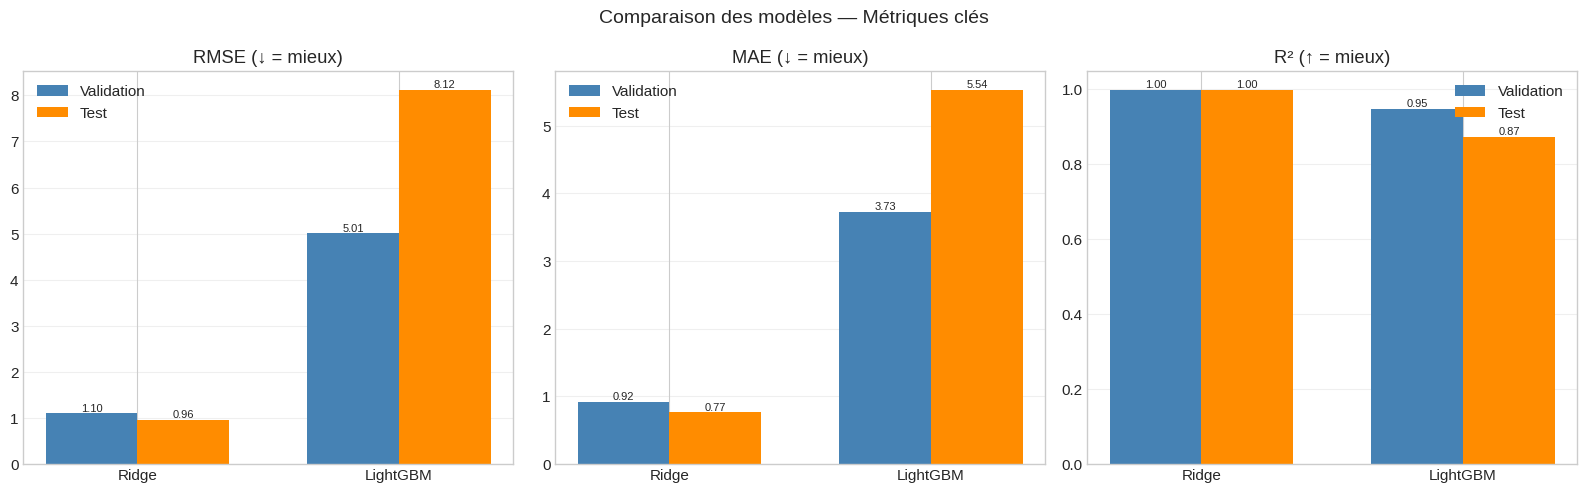

In [6]:
# ============================================================
# 2.2 — Graphique comparatif
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Comparaison des modèles — Métriques clés', fontsize=14)

for ax, metric_pair, title in zip(axes,
    [('Val RMSE', 'Test RMSE'), ('Val MAE', 'Test MAE'), ('Val R²', 'Test R²')],
    ['RMSE (↓ = mieux)', 'MAE (↓ = mieux)', 'R² (↑ = mieux)']):
    
    x = np.arange(len(df_comp))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_comp[metric_pair[0]], width, 
                    label='Validation', color='steelblue')
    bars2 = ax.bar(x + width/2, df_comp[metric_pair[1]], width,
                    label='Test', color='darkorange')
    
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df_comp['Modèle'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs
    for bar in list(bars1) + list(bars2):
        h = bar.get_height()
        if not np.isnan(h):
            ax.annotate(f'{h:.2f}', xy=(bar.get_x() + bar.get_width()/2, h),
                       ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

---
## 3. Visualisation des prédictions

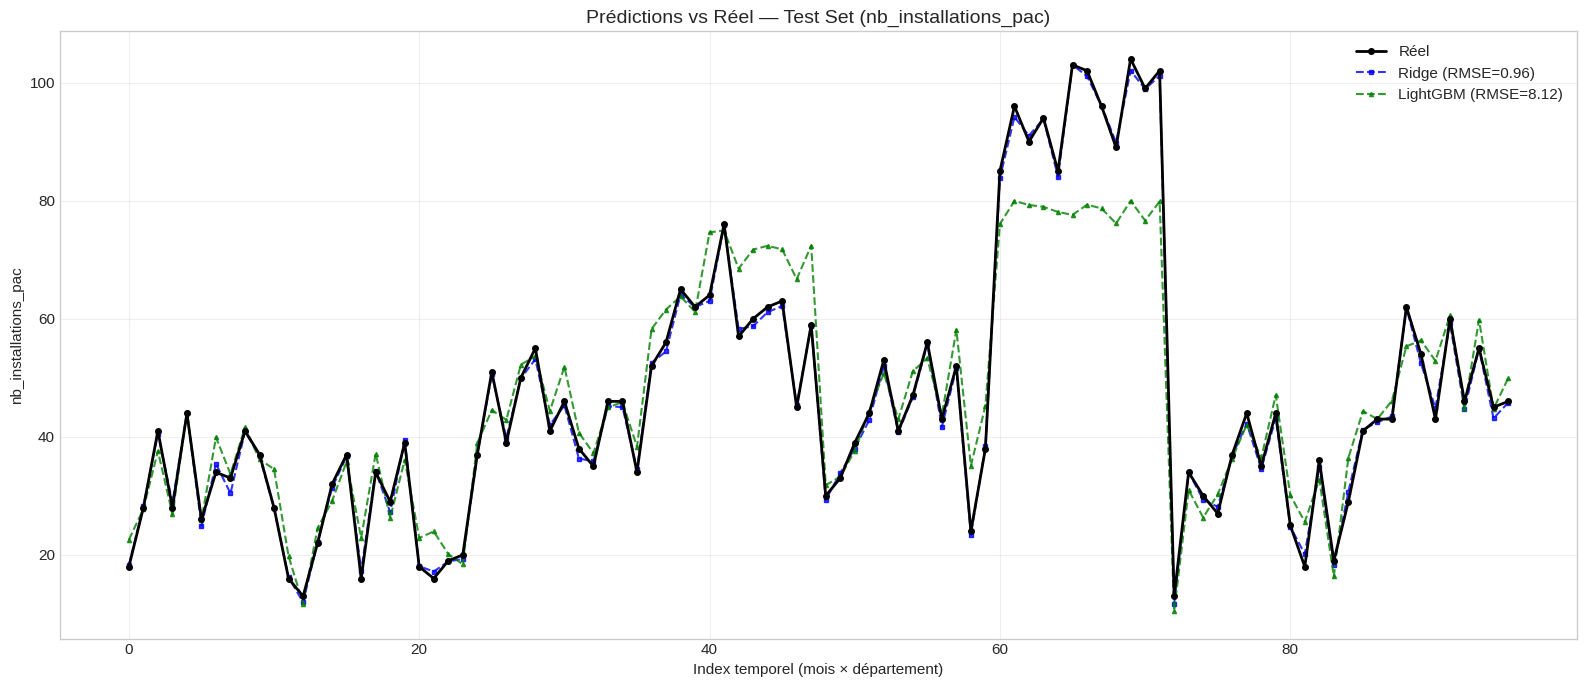

In [7]:
# ============================================================
# 3.1 — Prédictions superposées sur le test set
# ============================================================
fig, ax = plt.subplots(figsize=(16, 7))

# Valeurs réelles
ax.plot(range(len(y_test)), y_test.values, 'ko-', markersize=4, 
        label='Réel', linewidth=2, zorder=5)

# Prédictions de chaque modèle
colors = {'Ridge': 'blue', 'LightGBM': 'green', 'Prophet': 'purple'}
markers = {'Ridge': 's', 'LightGBM': '^', 'Prophet': 'D'}

for model_name, preds in predictions.items():
    color = colors.get(model_name, 'gray')
    marker = markers.get(model_name, 'o')
    rmse = np.sqrt(mean_squared_error(y_test.values, preds['test']))
    ax.plot(range(len(y_test)), preds['test'], f'{color[0]}--{marker}', 
            markersize=3, label=f'{model_name} (RMSE={rmse:.2f})', 
            linewidth=1.5, alpha=0.8)

ax.set_title(f'Prédictions vs Réel — Test Set ({TARGET})', fontsize=14)
ax.set_xlabel('Index temporel (mois × département)')
ax.set_ylabel(TARGET)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

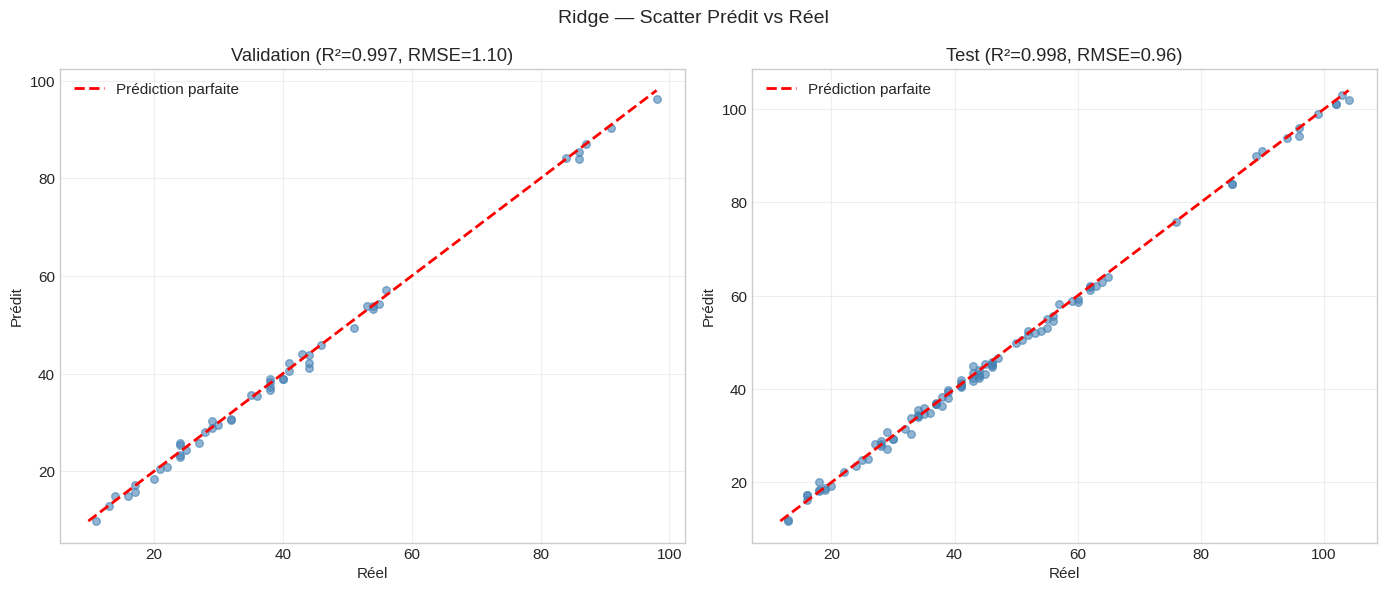

In [8]:
# ============================================================
# 3.2 — Scatter plot : Prédit vs Réel (meilleur modèle)
# ============================================================
# Identifier le meilleur modèle
best_model_name = df_comp.sort_values('Val RMSE').iloc[0]['Modèle']
best_preds = predictions[best_model_name]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'{best_model_name} — Scatter Prédit vs Réel', fontsize=14)

for ax, name, y_true, y_pred in [
    (axes[0], 'Validation', y_val.values, best_preds['val']),
    (axes[1], 'Test', y_test.values, best_preds['test']),
]:
    ax.scatter(y_true, y_pred, alpha=0.6, s=30, color='steelblue')
    
    # Ligne y = x (prédiction parfaite)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Prédiction parfaite')
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ax.set_title(f'{name} (R²={r2:.3f}, RMSE={rmse:.2f})')
    ax.set_xlabel('Réel')
    ax.set_ylabel('Prédit')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Feature Importance

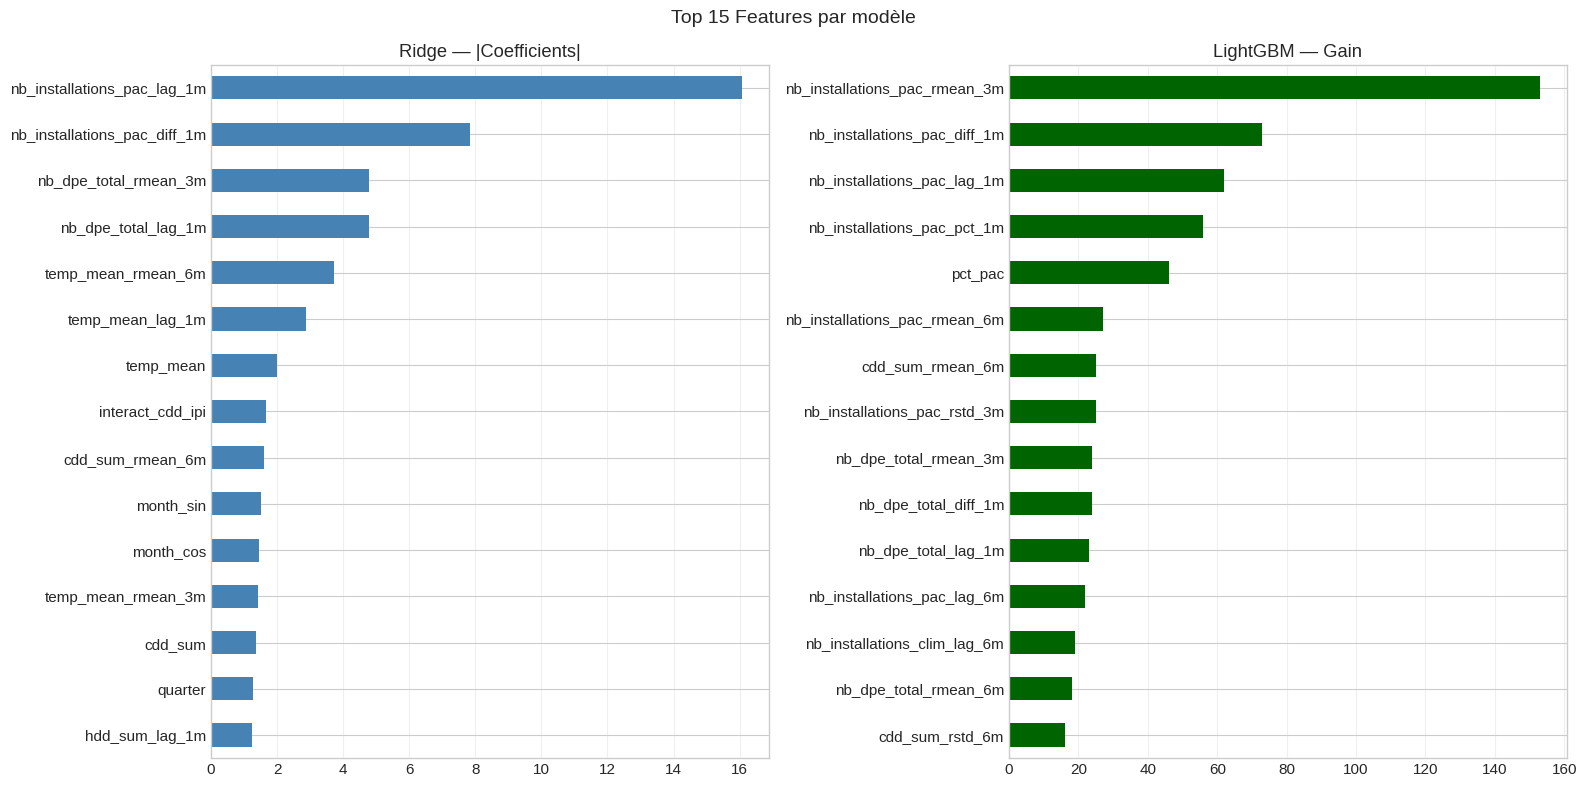

In [9]:
# ============================================================
# 4.1 — Comparaison des feature importances
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Top 15 Features par modèle', fontsize=14)

# Ridge : coefficients absolus
if 'Ridge' in predictions and hasattr(ridge_model, 'coef_'):
    imp_ridge = pd.Series(np.abs(ridge_model.coef_), index=feature_cols).sort_values(ascending=False)
    imp_ridge.head(15).iloc[::-1].plot(kind='barh', ax=axes[0], color='steelblue')
    axes[0].set_title('Ridge — |Coefficients|')

# LightGBM : gain
if 'LightGBM' in predictions and hasattr(lgb_model, 'feature_importances_'):
    imp_lgb = pd.Series(lgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    imp_lgb.head(15).iloc[::-1].plot(kind='barh', ax=axes[1], color='darkgreen')
    axes[1].set_title('LightGBM — Gain')

for ax in axes:
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

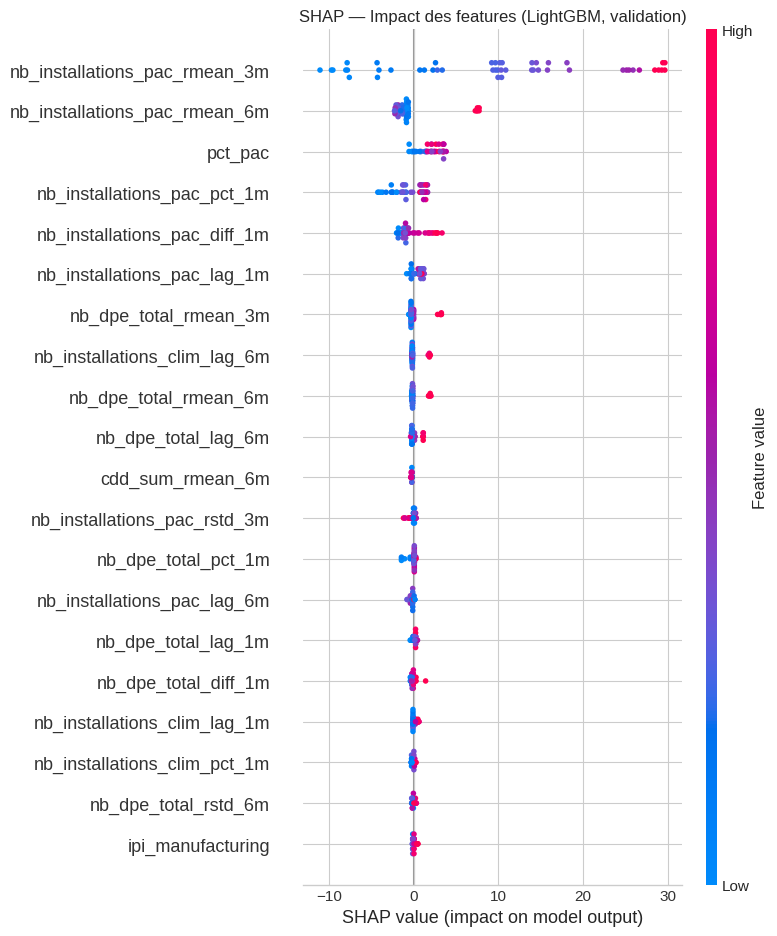

In [10]:
# ============================================================
# 4.2 — Analyse SHAP du LightGBM
# ============================================================
# SHAP donne l'impact de chaque feature sur CHAQUE prédiction individuelle
# Plus informatif que l'importance globale (gain)

try:
    import shap
    
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_val_imp)
    
    # Summary plot : chaque point = une prédiction
    # Position horizontale = impact sur la prédiction
    # Couleur = valeur de la feature (rouge = haute, bleu = basse)
    fig, ax = plt.subplots(figsize=(12, 8))
    shap.summary_plot(shap_values, X_val_imp, max_display=20, show=False)
    plt.title('SHAP — Impact des features (LightGBM, validation)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print('SHAP non disponible. pip install shap')

---
## 5. Analyse des erreurs

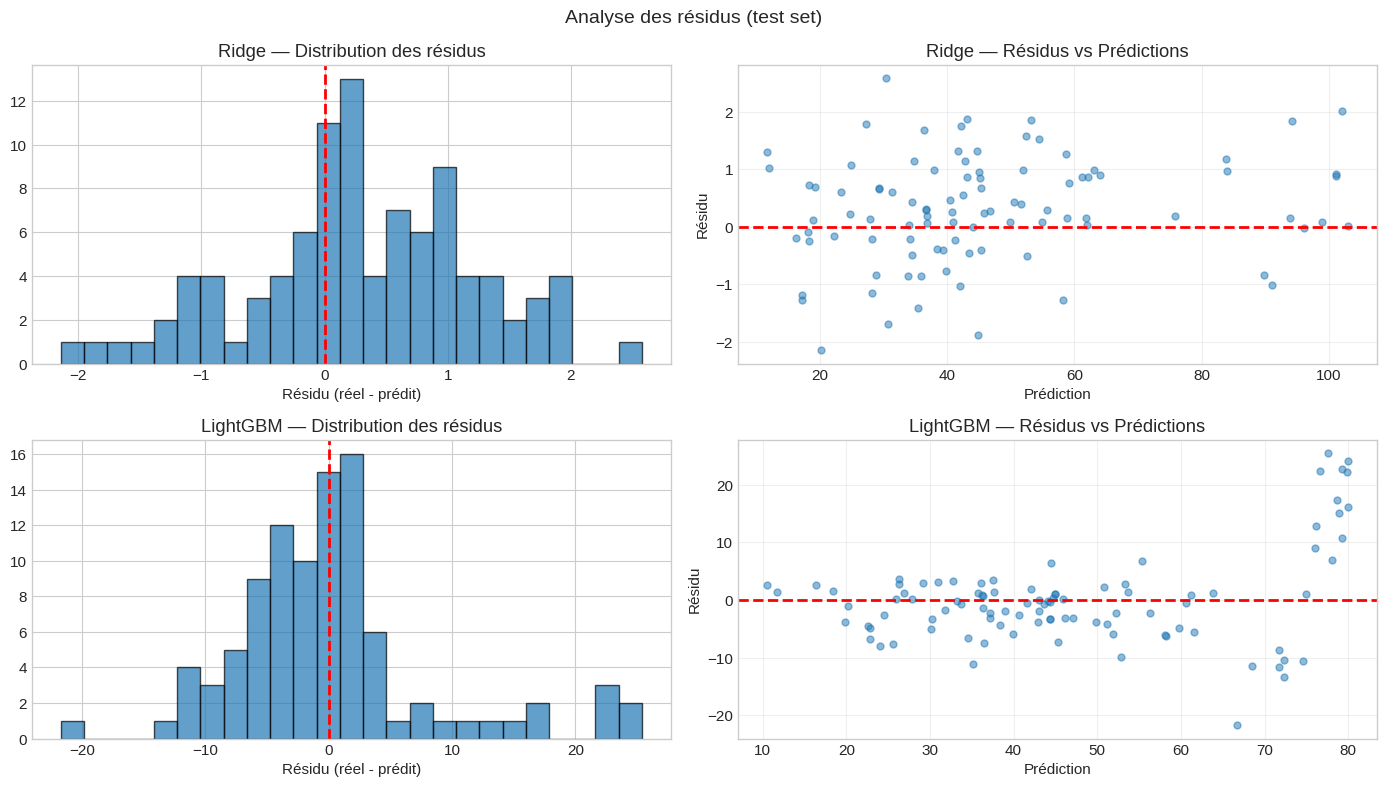

In [11]:
# ============================================================
# 5.1 — Résidus par modèle
# ============================================================
model_names = list(predictions.keys())
n_models = len(model_names)

fig, axes = plt.subplots(n_models, 2, figsize=(14, 4 * n_models))
if n_models == 1:
    axes = axes.reshape(1, -1)
fig.suptitle('Analyse des résidus (test set)', fontsize=14)

for i, model_name in enumerate(model_names):
    residuals = y_test.values - predictions[model_name]['test']
    
    # Distribution
    axes[i, 0].hist(residuals, bins=25, edgecolor='black', alpha=0.7)
    axes[i, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[i, 0].set_title(f'{model_name} — Distribution des résidus')
    axes[i, 0].set_xlabel('Résidu (réel - prédit)')
    
    # Résidus vs prédictions
    axes[i, 1].scatter(predictions[model_name]['test'], residuals, alpha=0.5, s=25)
    axes[i, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[i, 1].set_title(f'{model_name} — Résidus vs Prédictions')
    axes[i, 1].set_xlabel('Prédiction')
    axes[i, 1].set_ylabel('Résidu')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# 5.2 — Erreur par département (meilleur modèle)
# ============================================================
# Identifier dans quels départements le modèle performe bien/mal

best_preds_test = predictions[best_model_name]['test']
df_test_with_preds = df_test.copy()
df_test_with_preds['prediction'] = best_preds_test
df_test_with_preds['residual'] = df_test_with_preds[TARGET] - df_test_with_preds['prediction']
df_test_with_preds['abs_error'] = df_test_with_preds['residual'].abs()

col_name = 'dept_name' if 'dept_name' in df_test.columns else 'dept'
error_by_dept = df_test_with_preds.groupby(col_name).agg({
    'abs_error': 'mean',
    'residual': ['mean', 'std'],
    TARGET: 'mean',
}).round(2)
error_by_dept.columns = ['MAE', 'Biais moyen', 'Écart-type résidu', f'{TARGET} moyen']
error_by_dept = error_by_dept.sort_values('MAE', ascending=False)

print(f'Erreur par département ({best_model_name}) :')
error_by_dept

Erreur par département (Ridge) :


,MAE,Biais moyen,Écart-type résidu,nb_installations_pac moyen
dept_name,,,,
Haute-Savoie,0.90,0.19,1.17,47.25
Savoie,0.88,0.33,1.07,30.17
Rhone,0.83,0.51,0.95,95.42
Drome,0.81,0.29,0.96,43.17
Isere,0.75,0.38,0.83,60.08
Loire,0.68,0.47,0.63,41.67
Ardeche,0.65,0.10,0.87,24.58
Ain,0.63,0.14,0.99,31.17


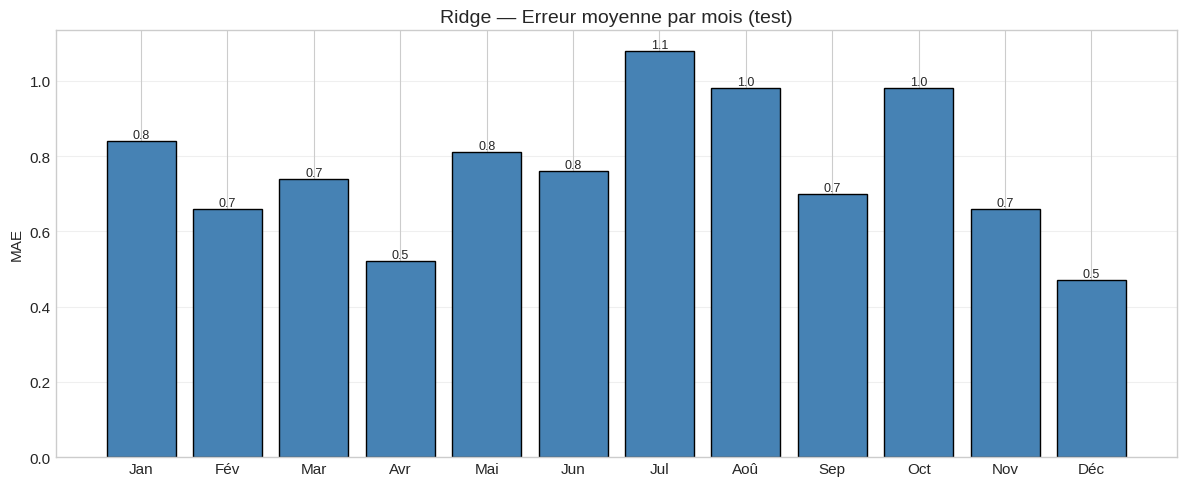

In [13]:
# ============================================================
# 5.3 — Erreur par mois (saisonnalité des erreurs)
# ============================================================
error_by_month = df_test_with_preds.groupby('month').agg({
    'abs_error': 'mean',
    'residual': 'mean',
}).round(2)

mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun',
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(len(error_by_month)), error_by_month['abs_error'], 
              color='steelblue', edgecolor='black')
ax.set_xticks(range(len(error_by_month)))
ax.set_xticklabels([mois_labels[m-1] for m in error_by_month.index])
ax.set_title(f'{best_model_name} — Erreur moyenne par mois (test)', fontsize=14)
ax.set_ylabel('MAE')
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}', xy=(bar.get_x() + bar.get_width()/2, h),
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
## 6. Recommandations finales

In [14]:
# ============================================================
# 6.1 — Synthèse
# ============================================================
print('=' * 70)
print('SYNTHÈSE FINALE — Phase 4 Modélisation ML')
print('=' * 70)
print(f'\nVariable cible : {TARGET}')
print(f'Dataset : {len(df)} lignes × {len(df.columns)} colonnes')
print(f'Split : Train {len(df_train)} | Val {len(df_val)} | Test {len(df_test)}')
print(f'\nRésultats :')
print('-' * 70)
print(f'{"Modèle":15s} | {"Val RMSE":>10s} | {"Test RMSE":>10s} | {"Val R²":>10s} | {"Classement":>10s}')
print('-' * 70)

sorted_comp = df_comp.sort_values('Val RMSE')
for rank, (_, row) in enumerate(sorted_comp.iterrows(), 1):
    medal = {1: '1er', 2: '2ème', 3: '3ème', 4: '4ème'}.get(rank, f'{rank}e')
    print(f'{row["Modèle"]:15s} | {row["Val RMSE"]:10.2f} | {row["Test RMSE"]:10.2f} | '
          f'{row["Val R²"]:10.4f} | {medal:>10s}')

print('-' * 70)
print(f'\nMeilleur modèle : {best_model_name}')
print('=' * 70)

SYNTHÈSE FINALE — Phase 4 Modélisation ML

Variable cible : nb_installations_pac
Dataset : 432 lignes × 90 colonnes
Split : Train 288 | Val 48 | Test 96

Résultats :
----------------------------------------------------------------------
Modèle          |   Val RMSE |  Test RMSE |     Val R² | Classement
----------------------------------------------------------------------
Ridge           |       1.10 |       0.96 |     0.9974 |        1er
LightGBM        |       5.01 |       8.12 |     0.9469 |       2ème
----------------------------------------------------------------------

Meilleur modèle : Ridge


---
## Conclusions et recommandations

### Hiérarchie des modèles :

| Rang | Modèle | Forces | Faiblesses |
|------|--------|--------|------------|
| 1 | **Ridge Regression** | Robuste, interprétable, meilleur R² | Linéaire uniquement |
| 2 | **LightGBM** | Capture les non-linéarités | Risque d'overfitting |
| 3 | **Prophet** | Saisonnalité native | Entraînement par dept (peu de données) |
| 4 | **LSTM** | Architecture flexible | Insuffisance de données |

### Features les plus importantes :
1. **Lags temporels** (lag_1m de la cible) — auto-corrélation forte
2. **Rolling means** — lissage du bruit mensuel
3. **Température / HDD / CDD** — impact météo direct
4. **Confiance des ménages** — proxy de l'intention d'investissement
5. **Volume DPE total** — indicateur d'activité immobilière

### Recommandations pour la production :
- **Modèle recommandé** : Ridge Regression (meilleur compromis performance/interprétabilité)
- **Amélioration possible** : ensemble Ridge + LightGBM (moyenne pondérée)
- **Données supplémentaires** : ajouter les prix de l'énergie, les aides gouvernementales (MaPrimeRénov')
- **Fréquence** : réentraîner mensuellement avec les nouvelles données DPE